# Contrast and Concentration Invariance
This notebook illustrates the following:
1. Decomposition of OSN and PN responses into steady-state and transient components,
2. Computing Odorant Concentration Contrast
3. Measuring concentration invariance and contrast boosting by comparing steady-state and transient
   OSN and PN responses to concentration waveform and concentration contrast.

Python version `>=3.8` is used for this notebook with the following required packages:
```
numpy>=1.20
matplotlib>=3.4
seaborn>=0.11
scipy>=1.8
tqdm>=4.60
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks
import seaborn as sns
from tqdm.auto import tqdm

In [2]:
data = np.load('../data/staircase.npz', allow_pickle=True)
t = data['t']
dt = t[1] - t[0]

## Plot raw data

[Text(0, 0.5, 'PSTH [Hz]')]

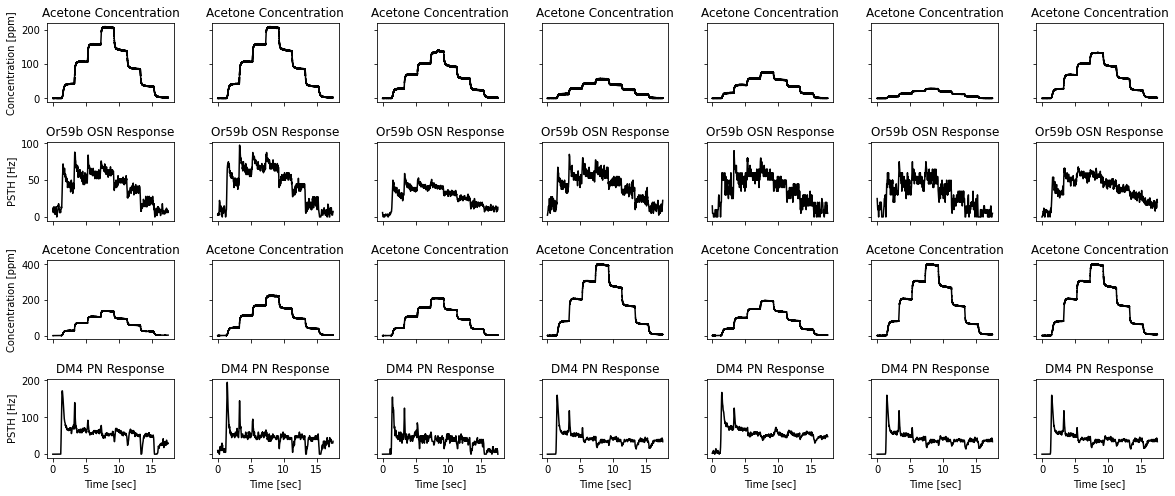

In [3]:
fig,axes = plt.subplots(
    4, 7, figsize=(20,8), 
    sharex=True, sharey='row', 
    gridspec_kw=dict(hspace=.5, wspace=.3)
)

for n, (osn_i, osn_o, pn_i, pn_o) in enumerate(zip(
    data['osn_input'],
    data['osn_output'],
    data['pn_input'],
    data['pn_output'],
)):
    axes[0,n].plot(t, osn_i, c='k')
    axes[0,n].set(title='Acetone Concentration')
    axes[1,n].plot(t, osn_o, c='k')
    axes[1,n].set(title='Or59b OSN Response')
    axes[2,n].plot(t, pn_i, c='k')
    axes[2,n].set(title='Acetone Concentration')
    axes[3,n].plot(t, pn_o, c='k')
    axes[3,n].set(title='DM4 PN Response')
_ = [ax.set(xlabel='Time [sec]') for ax in axes[-1]]
axes[0,0].set(ylabel='Concentration [ppm]')
axes[1,0].set(ylabel='PSTH [Hz]')
axes[2,0].set(ylabel='Concentration [ppm]')
axes[3,0].set(ylabel='PSTH [Hz]')

## Decompose PN responses to get transient and steady-state components

In [4]:
def get_contrast(t, stim, contrast_eps=1, axis=-1):
    dt = t[1] - t[0]
    b, a = butter(5, 15, fs=1 / dt)
    stim_smooth = lfilter(b, a, np.clip(stim, 0, np.inf), axis=axis)
    d_stim = np.diff(stim_smooth, axis=axis, prepend=stim_smooth[:, [0]]) / dt
    contrast_stim = d_stim / (contrast_eps + stim_smooth)
    return contrast_stim

In [5]:
def decompose_signal(
    t, stim, out, t_bounds=None, axis=-1, contrast_eps=1.0, ss_window=0.5
):
    dt = t[1] - t[0]
    # compute contrast
    contrast_stim = get_contrast(t, stim, axis=axis)
    # find timing of peak contrasts (both positive and negative)
    pos_peaks_contrast = np.sort(
        np.concatenate(
            [
                find_peaks(
                    contrast_stim[0], height=2.5, width=100, distance=int(1.7 // dt)
                )[0],
                find_peaks(
                    -contrast_stim[0], height=2.5, width=100, distance=int(1.7 // dt)
                )[0],
            ]
        )
    )
    pos_peaks_contrast = np.concatenate([pos_peaks_contrast, [len(t)]])
    
    # find average response ss_window seconds before each contrast peak
    ss = np.zeros_like(out)
    ss_vals = np.zeros((out.shape[0], len(pos_peaks_contrast) - 1))
    for n, (start_idx, stop_idx) in enumerate(
        zip(pos_peaks_contrast[:-1], pos_peaks_contrast[1:])
    ):
        ss_amp = out[
            :,
            stop_idx - int((0.2 + ss_window) // (dt)) : 
            stop_idx - int(0.2 // (dt)),
        ].mean(axis=1)
        ss_vals[:, n] = ss_amp
        ss[:, start_idx:stop_idx] = ss_amp[:, None]
    
    # compute peak as residual
    pk = out - ss
    return pos_peaks_contrast, ss_vals, ss, pk

In [6]:
def yyaxis(ax: plt.Axes, c: "color" = "red") -> plt.Axes:
    """Create A second axis with colored spine/ticks/label

    Note:
        This method will only make the twinx look like the color in
        MATLAB's :code:`yyaxis` function. However, unlike in MATLAB,
        it will not set the linestyle and linecolor of the lines that
        are plotted after twinx creation.

    Arguments:
        ax: the main axis to generate a twinx from
        c: color of the twinx, see https://matplotlib.org/stable/gallery/color/color_demo.html
            for color specifications accepted by matplotlib.
    """
    ax2 = ax.twinx()
    ax2.spines["right"].set_color(c)
    ax2.tick_params(axis="y", colors=c, which="both")
    ax2.yaxis.label.set_color(c)
    return ax2

[Text(0, 0.5, 'PSTH [Hz]')]

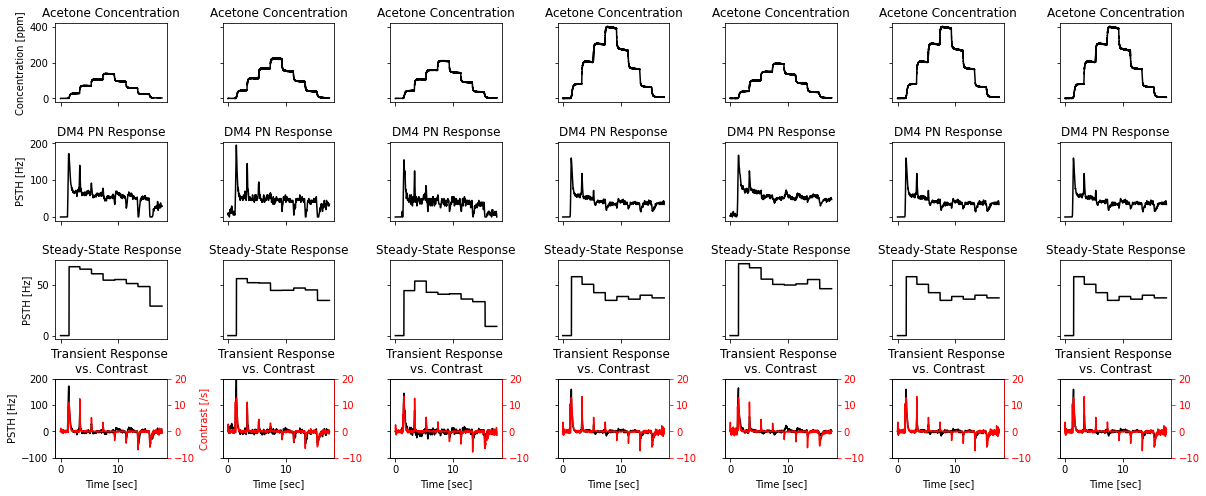

In [7]:
fig,axes = plt.subplots(
    4, 7, figsize=(20,8), 
    sharex=True, sharey='row', 
    gridspec_kw=dict(hspace=.5, wspace=.5)
)

for n, (pn_i, pn_o) in enumerate(zip(
    data['pn_input'],
    data['pn_output'],
)):
    peak_time, _, steady_state, peak = decompose_signal(t, pn_i[None,:], pn_o[None,:])
    u_contrast = get_contrast(t, pn_i[None,:])
    axes[0,n].plot(t, pn_i.T, c='k')
    axes[0,n].set(title='Acetone Concentration')
    axes[1,n].plot(t, pn_o.T, c='k')
    axes[1,n].set(title='DM4 PN Response')
    axes[2,n].plot(t, steady_state.T, c='k')
    axes[2,n].set(title='Steady-State Response')
    axes[3,n].plot(t, peak.T, c='k')
    axes[3,n].set(ylim=[-100, 200])
    ax2 = yyaxis(axes[3,n], c='r')
    ax2.plot(t, u_contrast.T, c='r')
    if n == 0:
        ax2.set(ylabel='Contrast [/s]')
    ax2.set(ylim=[-10, 20])
    axes[3,n].set(title='Transient Response \nvs. Contrast')
_ = [ax.set(xlabel='Time [sec]') for ax in axes[-1]]
axes[0,0].set(ylabel='Concentration [ppm]')
axes[1,0].set(ylabel='PSTH [Hz]')
axes[2,0].set(ylabel='PSTH [Hz]')
axes[3,0].set(ylabel='PSTH [Hz]')

## Correlation Steady-State vs. Concentration Waveform, Transient vs. Contrast

In [8]:
def corrcoef(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """Return Correlation Coefficient of two matricces"""
    mu_x = x.mean(1)
    mu_y = y.mean(1)
    x_center = x - mu_x[:, None]
    y_center = y - mu_y[:, None]
    num = (x_center * y_center).sum(1)
    den = np.linalg.norm(x_center, axis=1) * np.linalg.norm(y_center, axis=1)
    return num / (1e-15 + den)


In [9]:
delays = np.arange(int(-.1//dt), int(.1//dt), 10)
corr = dict(xy = [], corr = [], neuron=[])

for n, (inp, out) in tqdm(
    enumerate(zip(data['osn_input'], data['osn_output'])), 
    total=len(data['pn_input'])
):
    _, _, ss, pk = decompose_signal(t, inp[None,:], out[None,:])
    ss = np.squeeze(ss)
    pk = np.squeeze(pk)
    inp_contrast = np.squeeze(get_contrast(t, inp[None,:]))
    output_conc_corr = np.max(corrcoef(
        np.vstack([np.roll(out, d) for d in delays]),
        inp[None,:]
    ))
    ss_conc_corr = np.max(corrcoef(
        np.vstack([np.roll(ss, d) for d in delays]),
        inp[None,:]
    ))
    pk_conc_corr = np.max(corrcoef(
        np.vstack([np.roll(pk, d) for d in delays]),
        inp_contrast[None,:]
    ))
    
    corr['xy'].append('response vs. concentration')
    corr['corr'].append(output_conc_corr)
    corr['neuron'].append('osn')
    
    corr['xy'].append('steady-state vs. concentration')
    corr['corr'].append(ss_conc_corr)
    corr['neuron'].append('osn')
    
    corr['xy'].append('transient vs. contrast')
    corr['corr'].append(pk_conc_corr)
    corr['neuron'].append('osn')

for n, (inp, out) in tqdm(
    enumerate(zip(data['pn_input'], data['pn_output'])), 
    total=len(data['pn_input'])
):
    _, _, ss, pk = decompose_signal(t, inp[None,:], out[None,:])
    ss = np.squeeze(ss)
    pk = np.squeeze(pk)
    inp_contrast = np.squeeze(get_contrast(t, inp[None,:]))
    output_conc_corr = np.max(corrcoef(
        np.vstack([np.roll(out, d) for d in delays]),
        inp[None,:]
    ))
    ss_conc_corr = np.max(corrcoef(
        np.vstack([np.roll(ss, d) for d in delays]),
        inp[None,:]
    ))
    pk_conc_corr = np.max(corrcoef(
        np.vstack([np.roll(pk, d) for d in delays]),
        inp_contrast[None,:]
    ))
    
    corr['xy'].append('response vs. concentration')
    corr['corr'].append(output_conc_corr)
    corr['neuron'].append('pn')
    
    corr['xy'].append('steady-state vs. concentration')
    corr['corr'].append(ss_conc_corr)
    corr['neuron'].append('pn')
    
    corr['xy'].append('transient vs. contrast')
    corr['corr'].append(pk_conc_corr)
    corr['neuron'].append('pn')

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

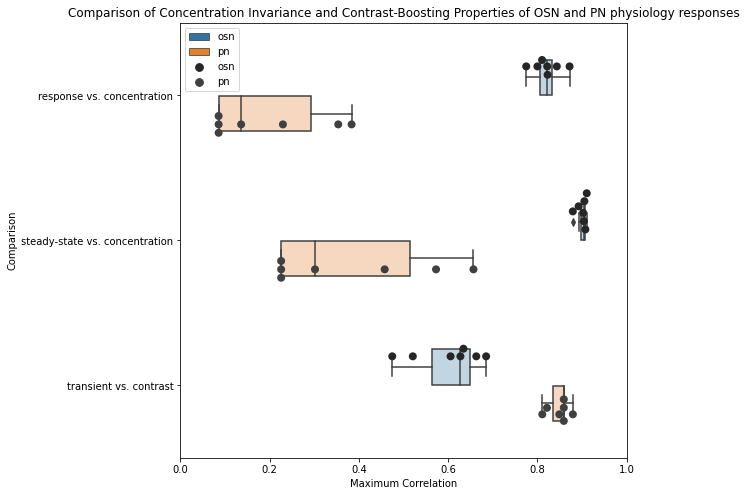

In [10]:
fig,ax = plt.subplots(1,1,figsize=(8,8))

vp = sns.boxplot(data=corr, x="corr", y="xy", hue="neuron", width=.5)
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
sns.swarmplot(data=corr, x="corr", y="xy", hue="neuron", dodge=True, size=8, color='.25')
_ = ax.set(
    xlim=[0, 1], 
    xlabel='Maximum Correlation', 
    ylabel='Comparison', 
    title='Comparison of Concentration Invariance and Contrast-Boosting Properties of OSN and PN physiology responses'
)